In [210]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, concatenate

In [211]:
df_no_weather = pd.read_csv('occ_app_for_chg_dmg_data/df_no_weather.csv')
df_no_weather_pred = pd.read_csv('occ_app_for_chg_dmg_data/df_no_weather_pred.csv')

In [212]:
df_no_weather= df_no_weather[['t', 'dayofweek', 'weekend', 'y_t_1', 'y']]

In [213]:
df_no_weather.head()

,t,dayofweek,weekend,y_t_1,y
0,2,2,0,6.504000,8.763500
1,3,3,0,8.763500,3.742333
2,4,4,0,3.742333,8.291333
3,5,5,0,8.291333,1.478000
4,6,6,1,1.478000,5.453333


In [214]:
df_no_weather_pred.head()

,weekday,weekend
0,0.317912,0.282021
1,0.317002,0.270882
2,0.313248,0.302579
3,0.295502,0.320241
4,0.295303,0.306273


### read data for hybrid LSTM

In [215]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [216]:
Z = pd.read_csv('occ_app_for_chg_dmg_data/df_no_weather.csv')
Z = Z.to_numpy()
Z.shape

n_steps_in = 12 # input y sequence for LSTM cell
n_steps_out = 6 # num of predicted steps. 
X, y = split_sequences(Z[:,3:5], n_steps_in, n_steps_out )

n_train=int(0.7*len(X))
n_train

1500

In [217]:
Z1 = pd.read_csv('occ_app_for_chg_dmg_data/df_no_weather_pred.csv')
Z1 = Z1.to_numpy()
Z1 = Z1.transpose()
Z1

array([[0.31791215, 0.31700243, 0.31324809, 0.29550166, 0.29530325,
        0.3092698 , 0.31489946, 0.31031509, 0.30200582, 0.32170263,
        0.30004395, 0.2882696 , 0.30255969, 0.30591496, 0.31489319,
        0.32338516, 0.30048604, 0.30200113, 0.30514246, 0.31805912,
        0.31418455, 0.30526192, 0.31301308, 0.31718323, 0.30450071,
        0.30625539, 0.30298699, 0.29523927, 0.27347046, 0.27597714,
        0.19321612],
       [0.28202085, 0.27088225, 0.30257939, 0.32024121, 0.30627291,
        0.2758864 , 0.28217405, 0.28398111, 0.29728039, 0.27905345,
        0.30492935, 0.30181827, 0.29161193, 0.27644512, 0.30398961,
        0.28116483, 0.28160628, 0.3097238 , 0.2955401 , 0.2968595 ,
        0.2900046 , 0.28713474, 0.2700854 , 0.26602479, 0.33513676,
        0.3086348 , 0.29446329, 0.28672284, 0.26738065, 0.24451089,
        0.1410636 ]])

In [218]:
Z2 =np.concatenate((Z1,Z1),axis=1) 
X2 = np.zeros([len(Z),3+Z2.shape[1]],float)
X2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [219]:
for i in range(len(Z)-n_steps_in): 
    if Z[i+n_steps_in-1,-1]==0:      
       #  qq=np.array(Z2[0][Z[i+n_steps_in-1,0]:Z[i+n_steps_in-1,0]+n_steps_out])
        qq=np.array(Z2[0][0:Z2.shape[1]])
        X2[i]=np.append(Z[i+n_steps_in-1][0:3],qq) 
    else:            
        # qq=np.array(Z2[1][Z[i+n_steps_in-1,0]:Z[i+n_steps_in-1,0]+n_steps_out])
        qq=np.array(Z2[1][0:Z2.shape[1]])
        X2[i]=np.append(Z[i+n_steps_in-1][0:3],qq) 

In [220]:
X_train=X[0: n_train,];         y_train = y[0:n_train,]
X_test =X[n_train: len(X),];    y_test  = y[n_train:len(X),]

print(X_train.shape)
X_test.shape 

(1500, 12, 1)


(643, 12, 1)

In [221]:
X2_train=X2[0: n_train,]; X2_test =X2[n_train: len(X),];  
print(X2_train.shape)
X2_test.shape

(1500, 65)


(643, 65)

In [222]:
X_train[0,]

array([[ 8.7635    ],
       [ 3.74233333],
       [ 8.29133333],
       [ 1.478     ],
       [ 5.45333333],
       [ 7.653     ],
       [12.23      ],
       [ 7.63366667],
       [ 5.87975   ],
       [ 7.5475    ],
       [ 6.87625   ],
       [ 7.131     ]])

In [223]:
X2_train[0,]  

array([13.        ,  6.        ,  1.        ,  0.28202085,  0.27088225,
        0.30257939,  0.32024121,  0.30627291,  0.2758864 ,  0.28217405,
        0.28398111,  0.29728039,  0.27905345,  0.30492935,  0.30181827,
        0.29161193,  0.27644512,  0.30398961,  0.28116483,  0.28160628,
        0.3097238 ,  0.2955401 ,  0.2968595 ,  0.2900046 ,  0.28713474,
        0.2700854 ,  0.26602479,  0.33513676,  0.3086348 ,  0.29446329,
        0.28672284,  0.26738065,  0.24451089,  0.1410636 ,  0.28202085,
        0.27088225,  0.30257939,  0.32024121,  0.30627291,  0.2758864 ,
        0.28217405,  0.28398111,  0.29728039,  0.27905345,  0.30492935,
        0.30181827,  0.29161193,  0.27644512,  0.30398961,  0.28116483,
        0.28160628,  0.3097238 ,  0.2955401 ,  0.2968595 ,  0.2900046 ,
        0.28713474,  0.2700854 ,  0.26602479,  0.33513676,  0.3086348 ,
        0.29446329,  0.28672284,  0.26738065,  0.24451089,  0.1410636 ])

############
### Mix_LSTM
##############

In [224]:
X_train.shape

(1500, 12, 1)

In [225]:
n_features = 1  # one feature for the input of the LSTM cell
n_n_lstm = 36
dropout = 0.2

In [226]:
# ------------------ Hybrid LSTM Model Architecture ------------------

# Input 1: Sequential data input for the LSTM model. This could be historical data, with 'n_steps_in' time steps and 'n_features' features
# Input 2: External factors that could influence the charging demand. These could be factors like weather, events, or holidays.
input1 = Input(shape=(n_steps_in, n_features)) 
input2 = Input(shape=(X2_train.shape[1],)) 

# LSTM layer to process the sequential input data
model_LSTM = LSTM(n_n_lstm)(input1)
model_LSTM = Dropout(dropout)(model_LSTM) 
model_LSTM = Dense(18, activation='relu')(model_LSTM) 

# Dense layers to process the external factors (input 2)
# These layers will extract and transform relevant features from the external factors
meta_layer = Dense(X2_train.shape[1], activation="relu")(input2)
meta_layer = Dense(64, activation="relu")(meta_layer)
meta_layer = Dense(32, activation="relu")(meta_layer) 

# Concatenate the output from the LSTM model and the processed external factors
# This step combines the temporal information from the LSTM with the external factors for a comprehensive prediction
model_merge = concatenate([model_LSTM, meta_layer])
model_merge = Dense(100, activation='relu')(model_merge)  # This layer integrates the information from both the LSTM output and external factors
model_merge = Dropout(dropout)(model_merge)

# Final output layer with sigmoid activation
# This layer outputs the predicted charging demand for each of the future time steps
output = Dense(n_steps_out, activation='sigmoid')(model_merge)  

# Define the complete model with two inputs (sequential data and external factors) and one output (predicted demand)
model = Model(inputs=[input1, input2], outputs=output)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 12, 1)]      0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 65)]         0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 36)           5472        ['input_9[0][0]']                
                                                                                                  
 dense_25 (Dense)               (None, 65)           4290        ['input_10[0][0]']               
                                                                                            

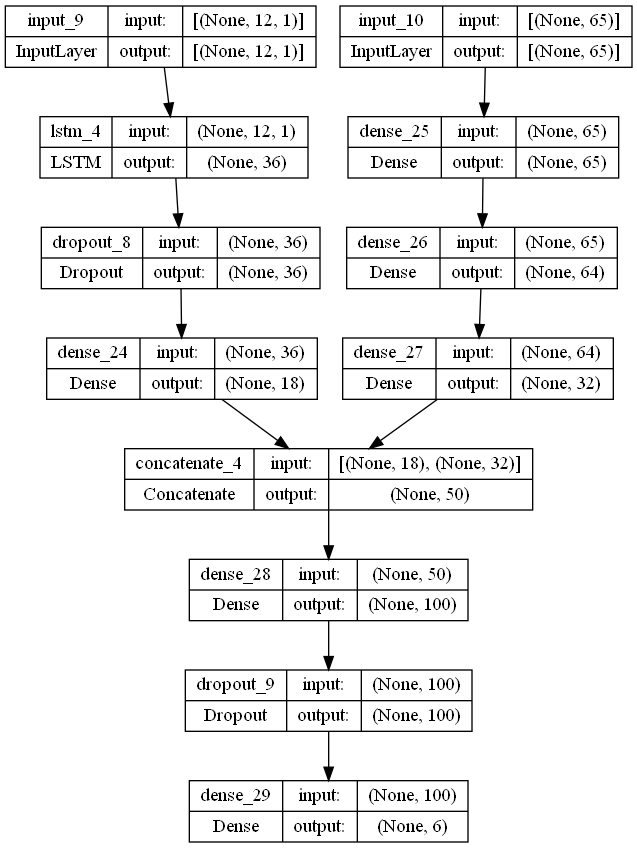

In [227]:
keras.utils.plot_model(model, show_shapes=True)

In [229]:
n_epoch=20
bat_size= 30


model.fit([X_train, X2_train], y_train, epochs=n_epoch, batch_size=bat_size,verbose=2)

Epoch 1/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 423ms/epoch - 8ms/step
Epoch 2/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 369ms/epoch - 7ms/step
Epoch 3/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 368ms/epoch - 7ms/step
Epoch 4/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 341ms/epoch - 7ms/step
Epoch 5/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 350ms/epoch - 7ms/step
Epoch 6/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 369ms/epoch - 7ms/step
Epoch 7/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 434ms/epoch - 9ms/step
Epoch 8/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 411ms/epoch - 8ms/step
Epoch 9/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 363ms/epoch - 7ms/step
Epoch 10/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 - 411ms/epoch - 8ms/step
Epoch 11/20
50/50 - 0s - loss: 65.2114 - mean_absolute_error: 7.7726 